In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
from wordcloud import WordCloud
import plotly.express as px
import missingno
from textblob import TextBlob
from ipywidgets import interact
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from ipywidgets import interact_manual
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pickle
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")

In [2]:
data=pd.read_csv("drug.csv",parse_dates=[5])
data.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,2012-05-20,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,2010-04-27,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,2009-12-14,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,2015-11-03,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,2016-11-27,37


In [3]:
pd.DataFrame({"features":data.columns,"dtypes":data.dtypes.values,"Null":data.isnull().sum().values}).style.background_gradient(cmap="Blues")

,features,dtypes,Null
0,uniqueID,int64,0
1,drugName,object,0
2,condition,object,899
3,review,object,0
4,rating,int64,0
5,date,datetime64[ns],0
6,usefulCount,int64,0


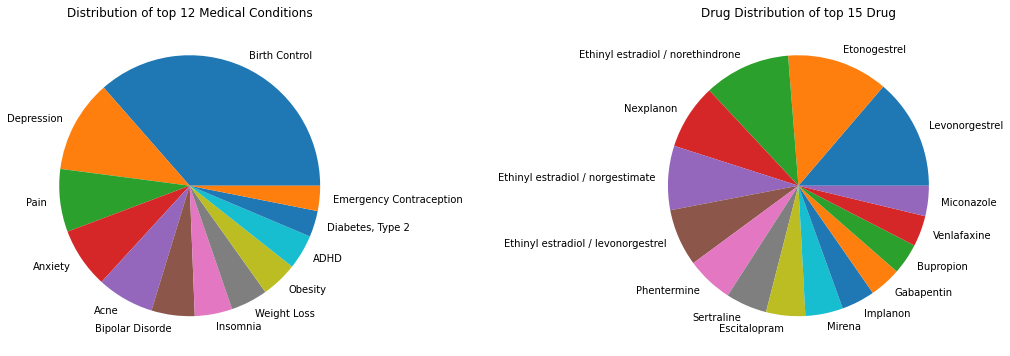

In [11]:
plt.rcParams["figure.figsize"]=(20,6)
plt.subplot(1,2,1)
plt.pie(data["condition"].value_counts()[:12].values,labels=data["condition"].value_counts()[:12].keys())
plt.title("Distribution of top 12 Medical Conditions")
plt.subplot(1,2,2)
plt.pie(data["drugName"].value_counts()[:15].values,labels=data["drugName"].value_counts()[:15].keys())
plt.title("Drug Distribution of top 15 Drug")
plt.show()

In [12]:
data.describe().style.background_gradient(cmap="magma")

,uniqueID,rating,usefulCount
count,161297.000000,161297.000000,161297.000000
mean,115923.585305,6.994377,28.004755
std,67004.445170,3.272329,36.403742
min,2.000000,1.000000,0.000000
25%,58063.000000,5.000000,6.000000
50%,115744.000000,8.000000,16.000000
75%,173776.000000,10.000000,36.000000
max,232291.000000,10.000000,1291.000000


In [13]:
data.dropna(inplace=True)

In [14]:
data.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,2012-05-20,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,2010-04-27,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,2009-12-14,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,2015-11-03,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,2016-11-27,37


## For a Particular condition top Drugs

In [28]:
@interact
def get_(conditions=data["condition"].unique()):
  return data[data["condition"]==conditions][data.drop(columns=["uniqueID",
                                 "date","condition"]).columns].sort_values(by="rating",
                        ascending=False).head(5).style.background_gradient(cmap="hot")


interactive(children=(Dropdown(description='conditions', options=('Left Ventricular Dysfunction', 'ADHD', 'Bir…

In [36]:
@interact
def get_(conditions=data["condition"].unique()):
  df=data[data["condition"]==conditions][data.drop(columns=["uniqueID","date"]).columns]
  plt.rcParams["figure.figsize"]=(15,5)
  plt.subplot(1,2,1)
  sns.distplot(data["usefulCount"])
  plt.title("usefulCount distribution")
  plt.subplot(1,2,2)
  plt.pie(df["drugName"].value_counts()[:10].values,labels=df["drugName"].value_counts()[:10].keys())
  plt.title(f'drug distribution for {conditions}')
  plt.show()
  

interactive(children=(Dropdown(description='conditions', options=('Left Ventricular Dysfunction', 'ADHD', 'Bir…

## Find Usage of top Drug

In [37]:
df=data.groupby(["condition"]).agg({"usefulCount":"sum","drugName":';'.join}).reset_index()
df["drugName"]=df["drugName"].apply(lambda x: len(x.split(";")))
df.head()

,condition,usefulCount,drugName
0,0</span> users found this comment helpful.,0,104
1,10</span> users found this comment helpful.,280,28
2,110</span> users found this comment helpful.,110,1
3,11</span> users found this comment helpful.,110,10
4,121</span> users found this comment helpful.,121,1


In [38]:
df=df.sort_values(by="usefulCount",ascending=False)
df.head()

,condition,usefulCount,drugName
262,Depression,458918,9069
125,Anxiety,300272,5904
165,Birth Control,224326,28788
594,Pain,218605,6145
164,Bipolar Disorde,152603,4224


In [39]:
df.columns=["condition","usefulCount","drugscounts"]

In [40]:
df.shape

(884, 3)

In [41]:
len(data["condition"].unique())

884

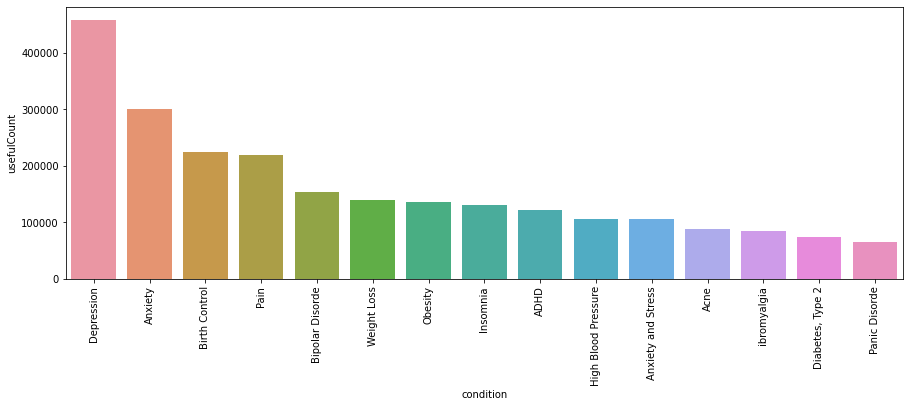

In [42]:
sns.barplot(df["condition"][:15],df["usefulCount"][:15])
plt.xticks(rotation="vertical")
plt.show()

# NO of Drugs exists and used for a Condition (in case of this dataset) 

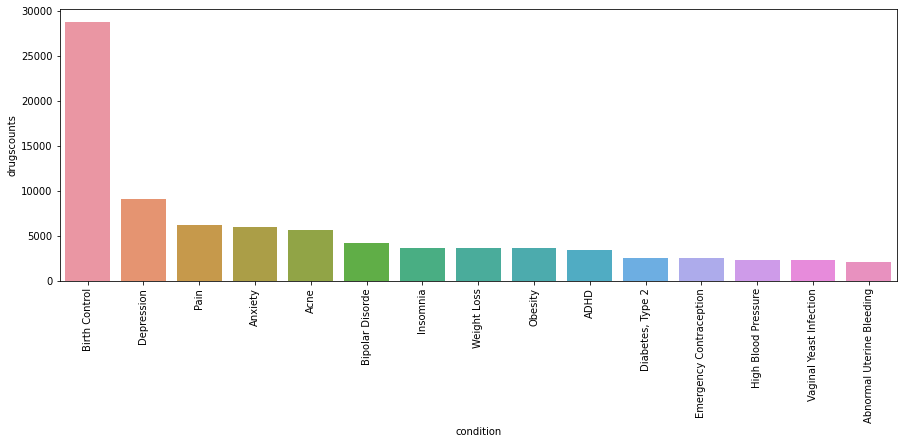

In [43]:
df2=df.sort_values(by="drugscounts",ascending=False)
sns.barplot(df2["condition"][:15],df2["drugscounts"][:15])
plt.xticks(rotation="vertical")
plt.show()

## Change in Usage With Time

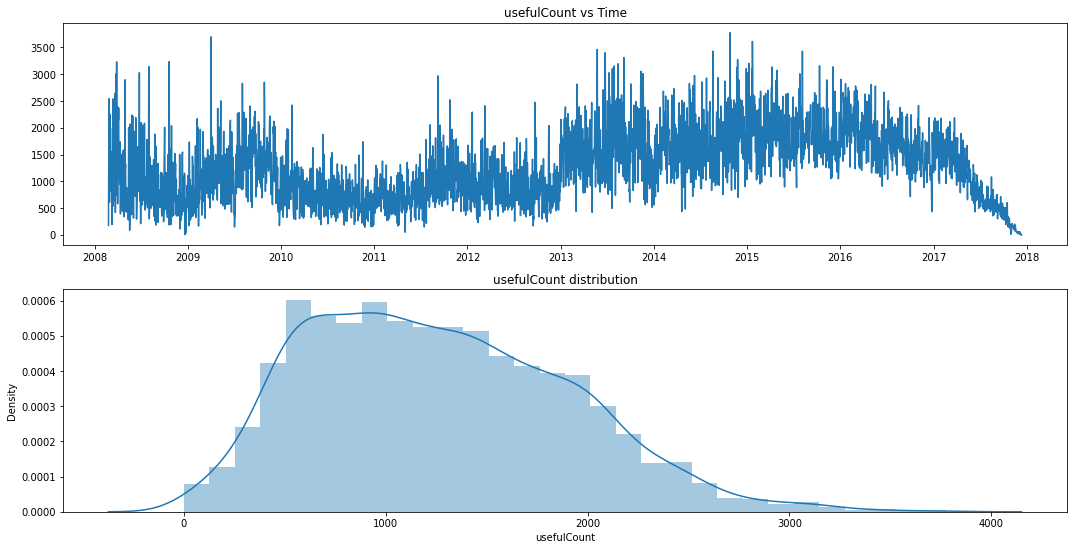

In [44]:
f=data.groupby("date").agg({"usefulCount":"sum"}).reset_index()
plt.rcParams["figure.figsize"]=(18,9)
plt.subplot(2,1,1)
plt.plot(f["date"],f["usefulCount"])
plt.title("usefulCount vs Time")
plt.subplot(2,1,2)
sns.distplot(f["usefulCount"])
plt.title("usefulCount distribution")
plt.show()

# For a particular condition, Resampled data or Usage of drugs

In [45]:
@interact
def get_(condition=data["condition"].unique(),arrange=["Y","Q","M","W","2Y","3Y","4Y"]):
  d=data.groupby(["date","condition"]).agg({"usefulCount":"sum"}).reset_index()
  d=d[d["condition"]==condition]
  k=d.groupby("date").agg({"usefulCount":"sum"})
  k=k.resample(f'{arrange}').mean().reset_index()
  k["usefulCount"]=k["usefulCount"].astype(int)
  return k.style.background_gradient(cmap="hot")



interactive(children=(Dropdown(description='condition', options=('Left Ventricular Dysfunction', 'ADHD', 'Birt…

In [27]:
@interact
def get_(condition=data["condition"].unique()):
  d=data.groupby(["date","condition"]).agg({"usefulCount":"sum"}).reset_index()
  d=d[d["condition"]==condition]
  k=d.groupby("date").agg({"usefulCount":"sum"}).reset_index()
  plt.rcParams["figure.figsize"]=(20,9)
  return (
      plt.subplot(2,1,1),
  plt.plot(k["date"],k["usefulCount"]),
  plt.title(f'usefulCount vs Time for {condition}'),
  plt.subplot(2,1,2),
  sns.distplot(k["usefulCount"]),
  plt.title(f'usefulCount distribution for {condition}'),
  plt.show()
  )

interactive(children=(Dropdown(description='condition', options=('Left Ventricular Dysfunction', 'ADHD', 'Birt…

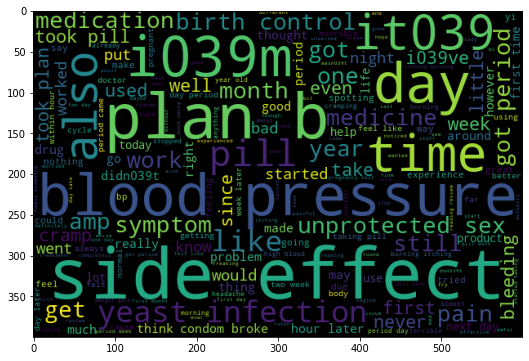

In [89]:
plt.imshow(WordCloud(width=600,height=400,stopwords=set(nltk.corpus.stopwords.words("english"))).generate(' '.join(data['review'].values)))

## yearly quaterly or monthly ploting

In [46]:
@interact
def get_(condition=data["condition"].unique(),arrange=["D","Y","Q","M","W","2Y","3Y","4Y"]):
  d=data.groupby(["date","condition"]).agg({"usefulCount":"sum"}).reset_index()
  d=d[d["condition"]==condition]
  k=d.groupby("date").agg({"usefulCount":"sum"})
  k=k.resample(f'{arrange}').mean().reset_index()
  return (
      plt.plot(k["date"],k["usefulCount"]),
      plt.show()
  )

interactive(children=(Dropdown(description='condition', options=('Left Ventricular Dysfunction', 'ADHD', 'Birt…

## Text Data Cleaning

In [47]:
data=data[(data["condition"]=="Emergency Contraception") | (data["condition"]=="High Blood Pressure") | (data["condition"]=="Vaginal Yeast Infection") | (data["condition"]=="Abnormal Uterine Bleeding") ]

In [55]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [56]:
def get_cleaned(sents):
  sents_punct_filtered=''.join([ i for i in sents if i not in string.punctuation])
  sents_punc_lower_filtered=' '.join([ i.lower() for i in nltk.tokenize.word_tokenize(sents_punct_filtered)])
  sents_punc_lower_stpw_filtered=' '.join([i for i in nltk.tokenize.word_tokenize(sents_punc_lower_filtered) if i not in nltk.corpus.stopwords.words("english")])
  sents_punc_lower_stpw_lemtz_filtered=' '.join([ nltk.stem.wordnet.WordNetLemmatizer().lemmatize(i) for i in nltk.tokenize.word_tokenize(sents_punc_lower_stpw_filtered)])
  return sents_punc_lower_stpw_lemtz_filtered
a=data["review"].apply(get_cleaned)
a

6         pulled cummed bit took plan b 26 hour later to...
24        use cream come turned hooha burning ring fire ...
33        burning control 20 minute inserting sat bath t...
40        prone yeast infection believe it039s due birth...
92        yes first use experience raw constant itching ...
                                ...                        
161207    extremely reluctant getting mirena heavy bleed...
161211    took along beta blockerand although mechanism ...
161251    fourth blood pressure pill feel like partly wo...
161258    bystolic foot arm numb blood sugar became seve...
161290    tekturna 9 day effect immediate also calcium c...
Name: review, Length: 9154, dtype: object

In [57]:
data.shape

(9154, 7)

In [58]:
data["review"]=a

## Finding Sentiments

In [60]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [61]:
def get_sentiment(sents):
  return SentimentIntensityAnalyzer().polarity_scores(sents).get("compound")
  # TextBlob(sents).sentiment.polarity/subjectivity (for polarity & subjectivity )
data["sentiment"]=data["review"].apply(get_sentiment)

In [62]:
data.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,sentiment
6,165907,Levonorgestrel,Emergency Contraception,pulled cummed bit took plan b 26 hour later to...,1,2017-03-07,5,0.0000
24,213649,Tioconazole,Vaginal Yeast Infection,use cream come turned hooha burning ring fire ...,1,2017-04-17,7,-0.3400
33,214453,Tioconazole,Vaginal Yeast Infection,burning control 20 minute inserting sat bath t...,1,2015-09-11,2,-0.4588
40,221934,Fluconazole,Vaginal Yeast Infection,prone yeast infection believe it039s due birth...,8,2017-04-24,9,0.0000
92,7337,Monistat 7-Day Combination Pack,Vaginal Yeast Infection,yes first use experience raw constant itching ...,8,2017-06-08,5,-0.7850


In [63]:
data=data[["condition","review"]]

In [64]:
data.head()

,condition,review
6,Emergency Contraception,pulled cummed bit took plan b 26 hour later to...
24,Vaginal Yeast Infection,use cream come turned hooha burning ring fire ...
33,Vaginal Yeast Infection,burning control 20 minute inserting sat bath t...
40,Vaginal Yeast Infection,prone yeast infection believe it039s due birth...
92,Vaginal Yeast Infection,yes first use experience raw constant itching ...


In [65]:
data["condition"].value_counts()

Emergency Contraception      2463
High Blood Pressure          2321
Vaginal Yeast Infection      2274
Abnormal Uterine Bleeding    2096
Name: condition, dtype: int64

In [66]:
encode=LabelEncoder()
data["labeled_condition"]=encode.fit_transform(data["condition"])
data.head()

,condition,review,labeled_condition
6,Emergency Contraception,pulled cummed bit took plan b 26 hour later to...,1
24,Vaginal Yeast Infection,use cream come turned hooha burning ring fire ...,3
33,Vaginal Yeast Infection,burning control 20 minute inserting sat bath t...,3
40,Vaginal Yeast Infection,prone yeast infection believe it039s due birth...,3
92,Vaginal Yeast Infection,yes first use experience raw constant itching ...,3


## Model Building 

In [70]:
from sklearn.naive_bayes import MultinomialNB,GaussianNB,BernoulliNB

Interactive Performance Analyzer

interactive(children=(Dropdown(description='Model', options=(MultinomialNB(), GaussianNB(), BernoulliNB(), SVC…

0.977607864554888 is the Accuracy
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       401
           1       0.99      0.97      0.98       496
           2       0.98      0.98      0.98       455
           3       0.97      0.98      0.98       479

    accuracy                           0.98      1831
   macro avg       0.98      0.98      0.98      1831
weighted avg       0.98      0.98      0.98      1831
 is the classification report


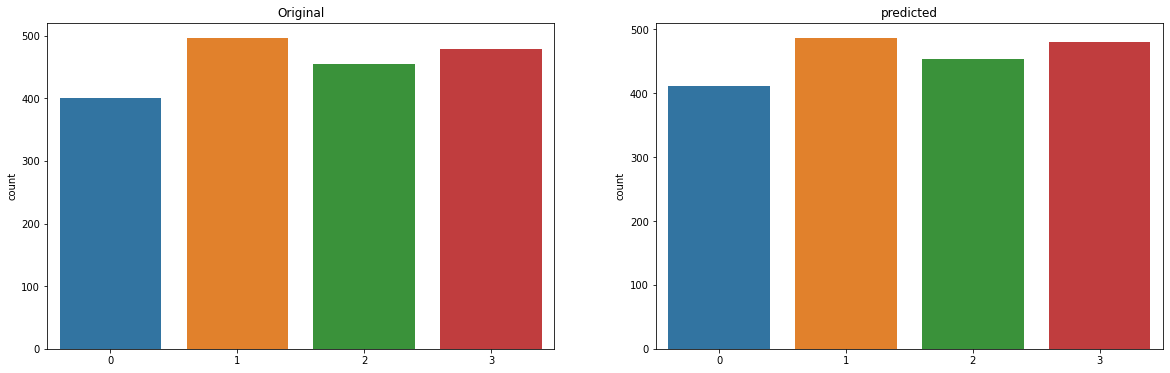

(<matplotlib.axes._subplots.AxesSubplot at 0x7fc0c1be30d0>,
 Text(0.5, 1.0, 'Original'),
 Text(0.5, 1.0, 'predicted'),
 None)

In [71]:
@interact_manual
def apply(Model=[MultinomialNB(),GaussianNB(),BernoulliNB(),SVC()],vectorizer=[CountVectorizer(max_features=3000),
                                                                                    TfidfVectorizer(max_features=3000)]):
  x=vectorizer.fit_transform(data["review"]).toarray()
  y=data["labeled_condition"].values
  x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)
  Model.fit(x_train,y_train)
  print(f'{Model.score(x_test,y_test)} is the Accuracy')
  print(f'{classification_report(y_test,Model.predict(x_test))} is the classification report')
  plt.rcParams["figure.figsize"]=(20,6)
  return (
      plt.subplot(1,2,1),
      sns.countplot(y_test),
      plt.title("Original"),
      plt.subplot(1,2,2),
      sns.countplot(Model.predict(x_test)),
      plt.title("predicted"),
      plt.show()
  )


In [72]:
vectorizer=CountVectorizer(max_features=3000)
x=vectorizer.fit_transform(data["review"]).toarray()
y=data["labeled_condition"].values
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)

## Multinomial Naive Bayes

In [75]:
Model=MultinomialNB()
Model.fit(x_train,y_train)
print(f'Training Accuracy : {Model.score(x_train,y_train)}')
print(f'Testing Accuracy : {Model.score(x_test,y_test)} ')

print(classification_report(y_test,Model.predict(x_test)))

Training Accuracy : 0.9840229414174518
Testing Accuracy : 0.979792463134899 
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       424
           1       0.99      0.98      0.98       486
           2       0.97      0.98      0.98       460
           3       0.99      0.98      0.98       461

    accuracy                           0.98      1831
   macro avg       0.98      0.98      0.98      1831
weighted avg       0.98      0.98      0.98      1831



In [76]:
pickle.dump(Model,open('NaiveBayes.pkl','wb'))

## Supoort Vector Machine

In [77]:
Model=SVC()
Model.fit(x_train,y_train)
print(f'Training Accuracy : {Model.score(x_train,y_train)}')
print(f'Testing Accuracy : {Model.score(x_test,y_test)} ')

print(classification_report(y_test,Model.predict(x_test)))

Training Accuracy : 0.9862078383176294
Testing Accuracy : 0.9705079191698526 
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       424
           1       1.00      0.97      0.98       486
           2       0.91      1.00      0.95       460
           3       1.00      0.94      0.97       461

    accuracy                           0.97      1831
   macro avg       0.97      0.97      0.97      1831
weighted avg       0.97      0.97      0.97      1831



In [78]:
pickle.dump(Model,open('Support_Vector_Machines.pkl','wb'))

## Gaussian Naive Bayes

In [79]:
Model=GaussianNB()
Model.fit(x_train,y_train)
print(f'Training Accuracy : {Model.score(x_train,y_train)}')
print(f'Testing Accuracy : {Model.score(x_test,y_test)} ')

print(classification_report(y_test,Model.predict(x_test)))

Training Accuracy : 0.9288542946879694
Testing Accuracy : 0.9038776624795194 
              precision    recall  f1-score   support

           0       0.94      0.84      0.89       424
           1       0.80      0.96      0.87       486
           2       0.97      0.87      0.91       460
           3       0.95      0.94      0.95       461

    accuracy                           0.90      1831
   macro avg       0.91      0.90      0.90      1831
weighted avg       0.91      0.90      0.90      1831



In [80]:
pickle.dump(Model,open('Gaussian_Naive_Bayes.pkl','wb'))

## Bernoulli Naive Bayes

In [81]:
Model=BernoulliNB()
Model.fit(x_train,y_train)
print(f'Training Accuracy : {Model.score(x_train,y_train)}')
print(f'Testing Accuracy : {Model.score(x_test,y_test)} ')

print(classification_report(y_test,Model.predict(x_test)))

Training Accuracy : 0.9729619008603032
Testing Accuracy : 0.9650464227198252 
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       424
           1       1.00      0.95      0.98       486
           2       0.92      1.00      0.96       460
           3       0.99      0.95      0.97       461

    accuracy                           0.97      1831
   macro avg       0.97      0.97      0.97      1831
weighted avg       0.97      0.97      0.97      1831



In [82]:
pickle.dump(Model,open('Bernoulli_Naive_Bayes.pkl','wb'))